# Pulsed Resonator Spectroscopy vs Power with SHFQA or SHFQC

This notebook shows you how to perform pulsed resonator spectroscopy vs power in LabOne Q with a SHFQA or the quantum analyzer channels of a SHFQC. Here, you'll find the perform a 2D sweep of the frequency vs power on the qubit readout resonator to find the optimal settings at which to drive it.

## 0. LabOne Q Imports

You'll begin by importing `laboneq.simple` and some extra helper functions to run the examples. 

In [5]:
# LabOne Q:
from laboneq.simple import *

# Helpers:
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_results
from laboneq.contrib.example_helpers.generate_example_datastore import (
    generate_example_datastore,
    get_first_named_entry,
)

from pathlib import Path
import time

In [6]:
# Build an in-memory data store with device setup and qubit parameters for the
# example notebooks
setup_db = generate_example_datastore(in_memory=True)

In [7]:
# (re-) generate the dummy datstore used for loading device setup and qubit parameters for the example notebooks
generate_example_datastore()

setup_db = DataStore("laboneq_data/dummy_datastore.db")

## 1. Device Setup

Below, you'll create a device setup and specify to run in an emulated mode or on hardware, `emulate = True/False` respectively.

If you run on your hardware, the [descriptor](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment/) called by `create_device_setup` should be replaced by one of your own, generally stored as a [YAML file](https://docs.zhinst.com/labone_q_user_manual/concepts/set_up_equipment/#labone_q.func_concepts.setting_up.set_up_equipment.descriptor). Once you have this descriptor, it can be reused for all your experiments.

In [8]:
# load a calibrated device setup from the dummy database
device_setup = get_first_named_entry(
    db=setup_db, name="6_qubit_setup_shfsg_shfqa_hdawg_pqsc_calibrated"
)

emulate = True

\\home\home\sam68451\LabOneQ Software Local Samuel\laboneq\laboneq\dsl\calibration\oscillator.py:58: FutureWarning: `Oscillator` argument `carrier_type` will be removed in the future versions. It has no functionality.
  warnings.warn(


In [9]:
# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2023.10.09 11:04:08.549] INFO    Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\laboneq_output\log
[2023.10.09 11:04:08.560] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:04:08.563] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:04:08.573] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:04:08.608] INFO    Configuring the device setup
[2023.10.09 11:04:08.695] INFO    The device setup is configured


## 2. Experiment Parameters

Now you'll define the frequency sweep parameters, amplitude points, and pulse to use in your experiment.

In [10]:
# frequency range of spectroscopy scan -
# around expected centre frequency as defined in qubit parameters
start_freq = -500e6
stop_freq = 500e6
num_freq_points = 1001

# set number of points for amplitude sweep
num_amp_points = 21


# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"{qubit}_res_freq",
        start=start_freq,
        stop=stop_freq,
        count=num_points,
        axis_name="Frequency [Hz]",
    )


# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 4

# readout pulse parameters and definition
envelope_duration = 2.048e-6
envelope_rise_fall_time = 0.05e-6
readout_pulse = pulse_library.gaussian_square(
    uid="readout_pulse", length=envelope_duration, amplitude=0.9
)

## 3. Experiment Definition

 You'll now create a function which generates a resonator spectroscopy vs power [experiment](https://docs.zhinst.com/labone_q_user_manual/concepts/experiment/). In this experiment, you'll pass the `LinearSweepParameter` defined previously as an argument to the [sweep section](https://docs.zhinst.com/labone_q_user_manual/concepts/averaging_sweeping/#labone_q.func_concepts.experiment.averaging_sweeping.parameters_sweeps), as well as make a near-time sweep outside the real-time acquisition loop which sweeps the gain node of the SHFQA. Within the real-time frequency sweep section, you'll create a [section](https://docs.zhinst.com/labone_q_user_manual/concepts/sections_and_pulses/) containing a `play` and an `acquire` command.

In [11]:
def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_amp = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer, near-time loop - vary drive amplitude
    with exp_spec_amp.sweep(uid="res_amp", parameter=amplitude_sweep):
        # averaging loop
        with exp_spec_amp.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            # inner, real-time loop - vary drive frequency
            with exp_spec_amp.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec_amp.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec_amp.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec_amp.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=envelope_duration,
                    )
                with exp_spec_amp.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec_amp.delay(signal="measure", time=1e-6)

    exp_calibration = Calibration()
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    exp_spec_amp.set_calibration(exp_calibration)

    return exp_spec_amp

### 3.1 Experiment Calibration and Signal Map

Before running the experiment, you'll need to set an [experiment calibration](https://docs.zhinst.com/labone_q_user_manual/concepts/experiment_calibration/). The sweep parameter is assigned to the hardware oscillator modulating the readout resonator drive line. You'll also define and set the mapping between the experimental and logical lines.

In [12]:
# signal maps for the two different qubits - maps the logical signal of the device setup to the experimental signals of the experiment


def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map


amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.1, stop=0.99, count=num_amp_points
)
frequency_sweep = create_readout_freq_sweep(
    "q0", start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)
exp_spec_amp.set_signal_map(res_spec_map("q0"))

### 3.2 Compile and Generate Pulse Sheet

Now you'll compile the experiment and generate a pulse sheet.

In [13]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Spectroscopy_vs_Amplitude", compiled_spec_amp)

[2023.10.09 11:04:22.406] INFO    VERSION: laboneq 2.15.0
[2023.10.09 11:04:22.411] INFO    Connecting to data server at localhost:8004
[2023.10.09 11:04:22.414] INFO    Connected to Zurich Instruments LabOne Data Server version 23.06 at localhost:8004
[2023.10.09 11:04:22.426] INFO    Configuring the device setup
[2023.10.09 11:04:22.487] INFO    The device setup is configured
[2023.10.09 11:04:22.502] INFO    Starting LabOne Q Compiler run...
[2023.10.09 11:04:22.763] INFO    Schedule completed
[2023.10.09 11:04:23.917] INFO     ──────────────────────────────────────────────────────────────────── 
[2023.10.09 11:04:23.919] INFO      Device           AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.10.09 11:04:23.923] INFO     ──────────────────────────────────────────────────────────────────── 
[2023.10.09 11:04:23.928] INFO      SHFQA_dev12002     0         21            0           1      8192  
[2023.10.09 11:04:23.932] INFO     ───────────────────────────────────────────

u:\LabOneQ Software Local Samuel\laboneq\examples\01_qubit_characterization\Pulse_Sheets\Spectroscopy_vs_Amplitude_2023-10-09-11-04-23.html

### 3.3 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [14]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/{timestamp}_spec_amp_results.json")
print(f"File saved as Results/{timestamp}_spec_amp_results.json")

[2023.10.09 11:04:28.387] INFO    Configuring the device setup
[2023.10.09 11:04:28.389] INFO    The device setup is configured
[2023.10.09 11:04:28.431] INFO    Starting near-time execution...
[2023.10.09 11:04:28.923] INFO    Finished near-time execution.
File saved as Results/20231009T110428_spec_amp_results.json


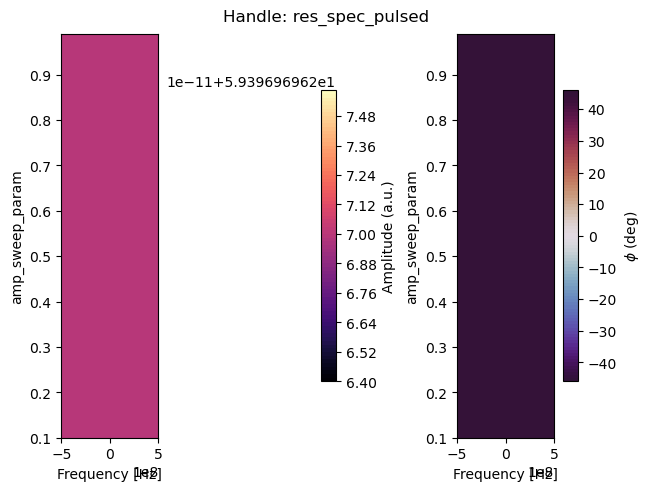

In [15]:
plot_results(spec_amp_results, phase=True)